In [401]:
import  matplotlib
%matplotlib inline
import matplotlib.pyplot as plt;
import seaborn as sns; sns.set()

import pyprob
from pyprob import Model
from pyprob.distributions import Normal, Uniform, Categorical, Beta

import torch
import numpy as np
import pandas as pd
import math
import random

In [2]:
faces_to_values = {str(i): i for i in range(2,11)}
faces_to_values['A'] = 1
for f in ['K', 'Q', 'J']:
    faces_to_values[f] = 10

In [3]:
class Card:
    def __init__(self, face):
        """
        Value: {1, ..., 10, 11, 12, 13} - 11 is J, 12 is Q, 13 is K
        """
        self.face = face
        self.value = faces_to_values[face]
    
    def __repr__(self):
        return self.face

In [6]:
deck = create_deck(2)

In [930]:
# class Blackjack(Model):
    
#     def __init__(self, num_decks):
#         super().__init__(name='Number game')
#         self.num_decks = num_decks
#         self.deck = self._create_decks()
#         self.cards = {}
    
#     def _create_decks(self):
#         deck = []
#         for _ in range(self.num_decks):
#             for face in faces_to_values.keys():
#                 new_card = Card(face)
#                 deck.append(new_card)

#         return deck
    
    
#     def _deal(self, deck):
#         np.random.shuffle(deck)
        
#         # Dealer
#         dealer_card1 = deck.pop()
#         dealer_card2 = deck.pop()
#         self.cards['dealer'] = [dealer_card1, dealer_card2]
        
#         # Player
#         player_card1 = deck.pop()
#         player_card2 = deck.pop()
#         self.cards['player'] = [player_card1, player_card2]
            
    
#     def compute_prob_draw_value(self, deck):
#         counts = np.zeros(11)
#         for card in deck:
#             counts[card.value] += 1
#         return counts

    
    
#     def forward(self):
#         """
#         Generative sampling process
#         """
#         score = 0  # latent variable to infer
        
#         deck_copy = self.deck.copy()
#         self._deal(deck_copy)
        
#         hidden_cards = self.cards['dealer']
        
#         score += hidden_cards[0].value + hidden_cards[1].value
        
#         for i in range(1,7):
#             if score < 16:
#                 likelihood = Categorical(self.compute_prob_draw_value(self.deck))
#                 new_card = deck_copy.pop()
#                 pyprob.observe(likelihood, name='obs{}'.format(i))
#                 score += new_card.value
#             else:
#                 probs = np.zeros(11)
#                 probs[0] = 1
#                 deterministic = Categorical(probs)
#                 pyprob.observe(deterministic, name='obs{}'.format(i))
        
#         return score
    
    
# model = Blackjack(num_decks=2)
# model_nn = Blackjack(num_decks=2)

In [947]:
class Deck():
    def __init__(self, num_suites):
        self.value_dict = {i:0 for i in range(11)}
        self.num_suites = num_suites
        
        for _ in range(num_suites):
            for face in faces_to_values.keys():
                new_card = Card(face)
                self.value_dict[new_card.value] += 1
    
    def get_value_probs(self):
        return list(self.value_dict.values())[::]
    
    def get_value_probs_dict(self):
        total_sum = sum(list(self.value_dict.values()))
        return {i:val/float(total_sum) for i,val in self.value_dict.items()}
    
    def __rep__(self):
        return self.value_dict
    
    def draw_card(self):
        value = int(pyprob.sample(Categorical(self.get_value_probs())))
        self.value_dict[value] -= 1
        return value
    
    def copy(self):
        temp = Deck(self.num_suites)
        temp.value_dict = self.value_dict.copy()
        return temp


class Blackjack(Model):
    
    def __init__(self, num_suites):
        super().__init__(name='Number game')
        self.num_suites = num_suites
        self.cards = {}
    
    def _deal(self, deck):
        
        # Dealer
        dealer_card1 = deck.draw_card()
        dealer_card2 = deck.draw_card()
        self.cards['dealer'] = [dealer_card1, dealer_card2]
        
        # Player
        player_card1 = deck.draw_card()
        player_card2 = deck.draw_card()
        self.cards['player'] = [player_card1, player_card2]
        
    def forward_game(self):
        """
        Generative sampling process
        """                
        
        deck = Deck(self.num_suites)
        self._deal(deck)
        
        score = sum(self.cards['dealer'])
        
        for i in range(1,7):
            if score < 16:
                likelihood = Categorical(deck.get_value_probs())
                new_card = deck.draw_card()
                self.cards['dealer'].append(new_card)
                pyprob.observe(likelihood, name='obs{}'.format(i))
                score += new_card
            else:
                probs = np.zeros(11)
                probs[0] = 1
                deterministic = Categorical(probs)
                pyprob.observe(deterministic, name='obs{}'.format(i))
        
        return deck, self.cards['player'], self.cards['dealer'], score
            
    
    def forward(self):
        """
        Generative sampling process
        """                
        
        deck = Deck(self.num_suites)
        self._deal(deck)
        
        score = sum(self.cards['dealer'])
        
        for i in range(1,7):
            if score < 16:
                likelihood = Categorical(deck.get_value_probs())
                new_card = deck.draw_card()
                pyprob.observe(likelihood, name='obs{}'.format(i))
                score += new_card
            else:
                probs = np.zeros(11)
                probs[0] = 1
                deterministic = Categorical(probs)
                pyprob.observe(deterministic, name='obs{}'.format(i))
        
        return score
    
    
model = Blackjack(num_suites=4)
model_nn = Blackjack(num_suites=4)

In [948]:
model.forward()

22

# Prior on Dealer Score

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:02 | 0d:00:00:00 | #################### | 1000/1000 | 477.90       


/Users/theo/anaconda3/envs/csis/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  """


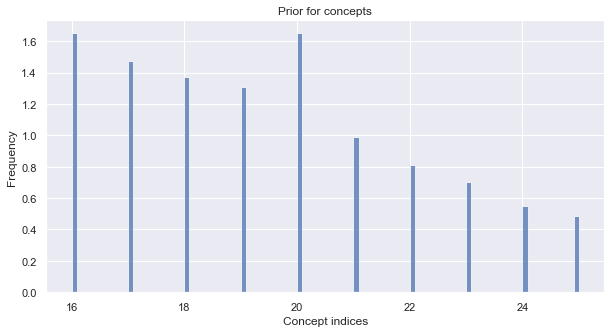

In [945]:
prior = model.prior_results(num_traces=1000)
prior.plot_histogram(show=False, alpha=0.75, label='empirical prior', bins=99)
plt.title('Prior for concepts')
plt.xlabel('Concept indices')
plt.show()

# Dealer Score Posterior - Importance Sampling

In [644]:
observations = {'obs1':5, 'obs2':10, 'obs3':0, 'obs4':0 , 'obs5':0, 'obs6':0}

### Many Samples

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:07 | 0d:00:00:00 | #################### | 4000/4000 | 500.13       


Text(0.5, 1.0, 'Importance Sampling Inferred Posterior')

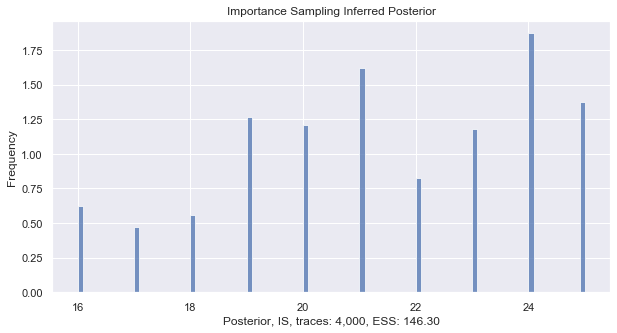

In [949]:
posterior_many = model.posterior_results(
                    num_traces=50000, # the number of samples estimating the posterior
                    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING, # specify which inference engine to use
                    observe=observations) # assign values to the observed values
posterior_many.plot_histogram(show=False, alpha=0.75, bins=99, label='inferred posterior')
plt.title('Importance Sampling Inferred Posterior')

### Few Samples

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:10 | 0d:00:00:00 | #################### | 5000/5000 | 488.33       


Text(0.5, 1.0, 'Importance Sampling Inferred Posterior')

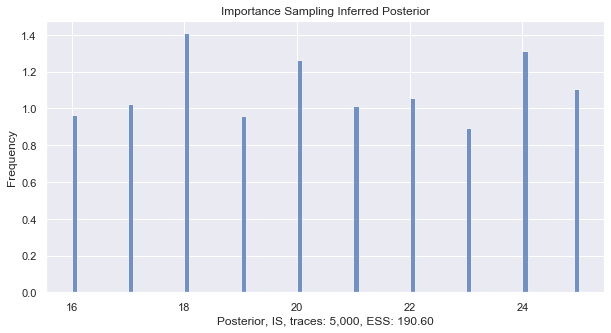

In [946]:
posterior_few = model.posterior_results(
                    num_traces=5000, # the number of samples estimating the posterior
                    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING, # specify which inference engine to use
                    observe=observations) 
posterior_few.plot_histogram(show=False, alpha=0.75, bins=99, label='inferred posterior')
plt.title('Importance Sampling Inferred Posterior')
# plt.savefig('images/importance_sampling_inferred_posterior_200.png')

# Inference Compilation

In [951]:
model_nn.learn_inference_network(num_traces=10000,
                              observe_embeddings={'obs1': {'dim' : 32},
                                                  'obs2': {'dim' : 32},
                                                  'obs3': {'dim' : 32},
                                                  'obs4': {'dim' : 32},
                                                  'obs5': {'dim' : 32},
                                                  'obs6': {'dim' : 32}},
                              inference_network=pyprob.InferenceNetwork.LSTM)

Continuing to train existing inference network...
Total number of parameters: 2,921,664
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
New layers, address: 16__forward__draw_card__?__Categorical(len_probs:1..., distribution: Categorical | 216.5 
Total addresses: 9, distribution types: 1, parameters: 3,058,551
0d:00:00:55 | 1    | 11,008    | +1.20e+01 | +8.66e+00 | +1.01e+01 | 0d:00:00:04 | +1.00e-03 | 215.9                               
Stop condition reached. num_traces: 10000
0d:00:00:55 | 1    | 11,072    | +1.20e+01 | +8.66e+00 | +9.97e+00 | 0d:00:00:04 | +1.00e-03 | 197.1                               


In [617]:
posterior_nn = model_nn.posterior_results(num_traces=1000, # the number of samples estimating the posterior
                    inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, # specify which inference engine to use
                    observe=observations) # assign values to the observed values
posterior_nn.plot_histogram(show=False, bins=99, alpha=0.75, label='inferred posterior')
plt.title('Inference Network Importance Sampling Inferred Posterior')

Time spent  | Time remain.| Progress             | Trace     | Traces/sec


RuntimeError: invalid multinomial distribution (encountering probability entry < 0)

In [615]:
combined = posterior_2000.combine_duplicates()
hypothesis = [(combined[i], np.exp(combined._get_log_weight(i).item())) for i in range(combined._length) if np.exp(combined._get_log_weight(i).item()) > 0.00001]
sorted(hypothesis, key=lambda x: x[1], reverse=True)

[(22, 0.11799401758414134),
 (20, 0.10910054738622853),
 (17, 0.10540218620806194),
 (18, 0.10262842575734707),
 (16, 0.10223220303156243),
 (19, 0.09809358692543273),
 (23, 0.09598027415694763),
 (24, 0.09237005439960745),
 (25, 0.09148949296478279),
 (21, 0.08470921158588812)]

# Simulating Games

## My strategy

In [771]:
def calc_EV(x, deck, dealerDistribution):
    
    EV_table = {}
    
    def calc_EV_helper(x, deck, dealerDistribution):

        if x in EV_table:
            return EV_table[x]
                
        if x > 21:
            EV_table[x] = ((1 - dealerDistribution.p_bust) * (-1), False)
            return EV_table[x]
        
        elif x <= 21:
            
            EV_stay_dealer_bust = dealerDistribution.p_bust * (1)
            EV_stay_dealer_no_bust = (1 - dealerDistribution.p_bust) * (dealerDistribution.p_less_than(x) * (1) + dealerDistribution.p_greater_than(x) * (-1))
            EV_stay = EV_stay_dealer_bust + EV_stay_dealer_no_bust
            
            EV_hit = 0
            for val,prob in deck.get_value_probs_dict().items():
                if prob > 0:
                    deck_copy = deck.copy()
                    deck_copy.value_dict[val] -= 1
                    EV_hit += prob * calc_EV_helper(x + val, deck_copy, dealerDistribution)[0]

        if EV_hit > EV_stay:
            EV_table[x] = (EV_hit, True)
        else:
            EV_table[x] = (EV_stay, False)
        return EV_table[x]
    
    return calc_EV_helper(x, deck, dealerDistribution)
            
# deck = Deck(4)
# for i in range(1,30):
    
#     EV, play = calc_EV(i, deck, dist)
#     print(i, EV, play)

## Infer Dealer Distribution

In [911]:
class DealerDistribution:
    
    def __init__(self, posterior):
        self.posterior = posterior
        self.probs = {}
        self.p_bust = 0
        
        combined = posterior.combine_duplicates()
        posterior_probs = {combined[i]:np.exp(combined._get_log_weight(i).item()) for i in range(combined._length) if np.exp(combined._get_log_weight(i).item()) > 0.00001}
        for key, prob in posterior_probs.items():
            if key <= 21:
                self.probs[key] = prob
            else:
                self.p_bust += prob

    def p_less_than(self, x):
        p = 0
        for key,prob in self.probs.items():
            if key < x:
                p += prob
        return p
    
    def p_greater_than(self, x):
        p = 0
        for key,prob in self.probs.items():
            if key > x:
                p += prob
        return p
    
    def plot(self):
        self.posterior.plot_histogram(show=False, alpha=0.75, bins=99, label='inferred posterior')
        plt.title('Importance Sampling Inferred Posterior')
        return

# dist = DealerDistribution(hypothesis)
# print(dist.p_bust)
# dist.probs

In [912]:
def infer_dealer_score(dealer_cards, num_traces, use_nn=False):

    observations = {}
    for i in range(2,7):
        if i < len(dealer_cards):
            observations['obs{}'.format(i-1)] = dealer_cards[i]
        else:
            observations['obs{}'.format(i)] = 0
    print(observations)

    if use_nn:
        pass
    else:
        posterior = model.posterior_results(
                            num_traces=num_traces, # the number of samples estimating the posterior
                            inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING, # specify which inference engine to use
                            observe=observations) 
        
    dealer_posterior = DealerDistribution(posterior)
    return dealer_posterior

## Simulate n Games

In [913]:
def play(deck, player_cards, dealer_cards, dealer_dist):
    score = sum(player_cards)
    EV, should_hit = calc_EV(score, deck, dealer_dist)
    while should_hit:
        new_card = deck.draw_card()
        print(new_card)
        score += new_card
        EV, should_hit = calc_EV(score, deck, dealer_dist)
        
    print("Final Score: {}".format(score))
    return score

In [927]:
wealth = 0
n = 50

for i in range(n):

    deck, player_cards, dealer_cards, score = model.forward_game()
    print(player_cards, dealer_cards)
    inferred_dealer_dist = infer_dealer_score(dealer_cards, 5000)

    player_score = play(deck, player_cards, dealer_cards, inferred_dealer_dist)
    dealer_score = sum(dealer_cards)
    wealth += payout(player_score, dealer_score)

print('\n')
print('Final Wealth after {} games: {}'.format(n, wealth))

[3, 4] [10, 1, 10]
{'obs1': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:09 | 0d:00:00:00 | #################### | 5000/5000 | 511.83       
7
Final Score: 14
[4, 6] [10, 2, 10]
{'obs1': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:10 | 0d:00:00:00 | #################### | 5000/5000 | 494.12       
1
4
Final Score: 15
[1, 6] [10, 4, 10]
{'obs1': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:09 | 0d:00:00:00 | #################### | 5000/5000 | 510.82       
6
10
Final Score: 23
[9, 5] [6, 10]
{'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:09 | 0d:00:00:00 | #################### | 5000/5000 | 507.58       
10
Final Score: 24
[8, 4] [5, 1, 10]
{

0d:00:00:10 | 0d:00:00:00 | #################### | 5000/5000 | 479.14       
Final Score: 19
[5, 4] [10, 2, 3, 8]
{'obs1': 3, 'obs2': 8, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:10 | 0d:00:00:00 | #################### | 5000/5000 | 476.41       
6
Final Score: 15
[9, 10] [10, 5, 10]
{'obs1': 10, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:10 | 0d:00:00:00 | #################### | 5000/5000 | 483.47       
Final Score: 19
[5, 10] [10, 6]
{'obs2': 0, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:10 | 0d:00:00:00 | #################### | 5000/5000 | 468.84       
3
Final Score: 18
[10, 3] [1, 7, 8]
{'obs1': 8, 'obs3': 0, 'obs4': 0, 'obs5': 0, 'obs6': 0}
Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:10 | 0d:00:00:00 | 

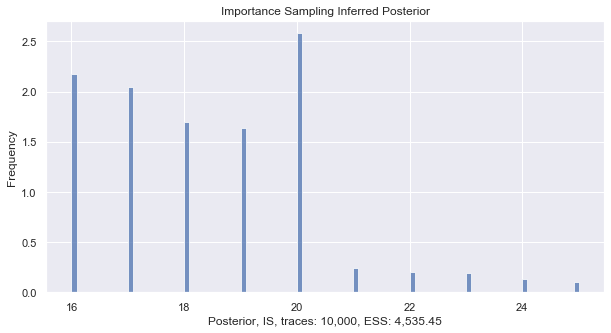

In [915]:
inferred_dealer_dist.plot()